# Insurance Cost Regression Study

## Introduction

### Project Overview

This project uses the Medical Cost Personal Dataset to predict insurance charges based on demographic and lifestyle factors. The goal is to assist insurance companies in pricing policies accurately and fairly.

### Objectives and Goals
1. Predict insurance charges using demographic and lifestyle data.
2. Evaluate how factors such as age, BMI, and smoking status affect insurance costs.
3. Compare different machine learning models for predictive performance.

### Research Questions
1. Can we build a robust regression model to predict insurance charges based on available features?
2. What are the key factors influencing insurance charges?
3. How does scaling affect regression model performance?
4. Can regularization (Lasso and Ridge) improve linear regression performance?
5. How do ensemble methods like Random Forest perform compared to simpler models?
6. Is hyperparameter tuning beneficial for improving model performance?
7. Can we integrate advanced methods for further improvement?
8. What insights can we derive from overfitting or underfitting analysis?

## Data Collection

### Data Exploration
Step 1: Load and Inspect Data
- Display initial rows and check dataset info.
- Calculate missing values and determine how to handle them.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import copy
from copy import deepcopy
from pandas.plotting import scatter_matrix

# Load the dataset
insurance_df = pd.read_csv("insurance-adapted.csv")
insurance_df.info()
insurance_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1318 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 73.3+ KB


age         20
sex          0
bmi          0
children     0
smoker       0
region       0
charges      0
dtype: int64

## Data Cleaning and Preprocessing

### Handle Missing Values
Impute age with median:
- Justification: Median is robust to outliers compared to mean.
- Research suggests missing values ≤5% are acceptable for imputation.

In [2]:
# Impute missing values in 'age' with the median
insurance_df.fillna({'age': insurance_df['age'].median()}, inplace=True)

## Exploratory Data Analysis (EDA)
Understand Data Distributions
- Visualize distributions of charges, age, and BMI.
- Implement statistical test to understand which features are important.
- Boxplots for categorical variables (smoker, sex, children, region) against charges.
- Line graphs for numerical variables (age, BMI).

### Target Distribution

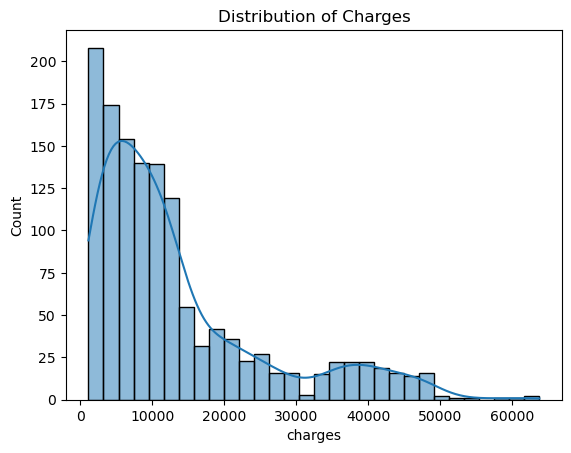

In [3]:
sns.histplot(insurance_df['charges'], kde=True)
plt.title("Distribution of Charges")
plt.show()

#### Insights
- This is acceptable distribution to continue.

### Statistical Test of Features

**Note**: Proper encoding ensures compatibility with machine learning models and avoids introducing bias. Techniques like one-hot encoding or label encoding are critical for handling categorical variables effectively [Kuhn & Johnson, 2013]. Label encoding will be implemented below to do statistical test in a correct structure.

In [4]:
# Create a deep copy of the DataFrame for statistical testing
insurance_df_copy = copy.deepcopy(insurance_df)

# Encoding categorical variables numerically for statistical testing
insurance_df_copy['smoker'] = insurance_df_copy['smoker'].map({'yes': 1, 'no': 0})
insurance_df_copy['sex'] = insurance_df_copy['sex'].map({'male': 1, 'female': 0})
insurance_df_copy['region'] = insurance_df_copy['region'].map({
    'northeast': 0, 
    'northwest': 1, 
    'southeast': 2, 
    'southwest': 3
})

# Define Features and Target
features = ['age', 'bmi', 'smoker', 'children', 'sex', 'region']
target = 'charges'

X_st = insurance_df_copy[features]
y_st = insurance_df_copy[target]

# Add constant for the intercept
X_st = sm.add_constant(X_st)

# Statistical Testing with Statsmodels
model = sm.OLS(y_st, X_st)  # Ordinary Least Squares Regression
results = model.fit()

# Display the p-values
print("\nP-values for each feature:")
print(results.pvalues)

# Filter significant features (p < 0.05)
significant_features = results.pvalues[results.pvalues < 0.05].index.tolist()
print("\nSignificant features (p < 0.05):", significant_features)

# Select only significant features (excluding 'const')
X_significant = X_st[significant_features]

# Fit the model again with significant features
final_model = sm.OLS(y_st, X_significant).fit()

# Display summary of the final model
print("\nFinal Model Summary:")
print(final_model.summary())


P-values for each feature:
const       9.265832e-34
age         4.174090e-88
bmi         2.518877e-32
smoker      0.000000e+00
children    4.173421e-04
sex         6.990130e-01
region      2.040236e-02
dtype: float64

Significant features (p < 0.05): ['const', 'age', 'bmi', 'smoker', 'children', 'region']

Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     797.9
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:53:45   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.715e+04
Df Model:                           5 

#### Insights
1. Significant Features:
    - Age (p-value: 4.17e-88): Strongly significant, has a strong relationship with charges.
    - BMI (p-value: 2.52e-32): Highly significant, correlates strongly with charges.
    - Smoker (p-value: 0.00): The most significant feature, a critical determinant of charges.
    - Children (p-value: 4.17e-04): Statistically significant, has a smaller but notable effect.
    - Region (p-value: 2.04e-02): Marginally significant, might have a weak impact on charges.
2.	Non-significant Feature:
	- Sex (p-value: 6.99e-01): Not significant, likely has little to no impact on charges.

Conclusion:
- Focus on age, BMI, smoker, children, and region for model training, and consider excluding sex due to its lack of statistical significance.

### Graphs for Categorical Features

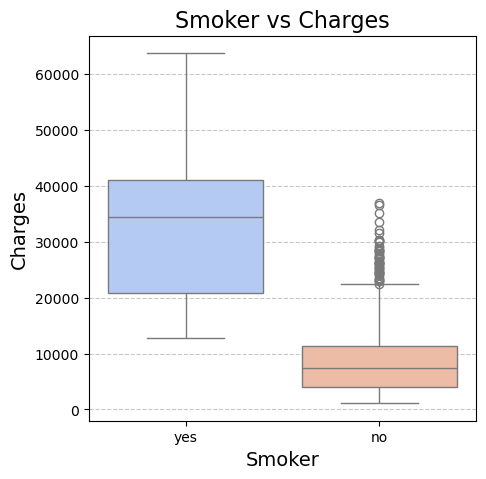

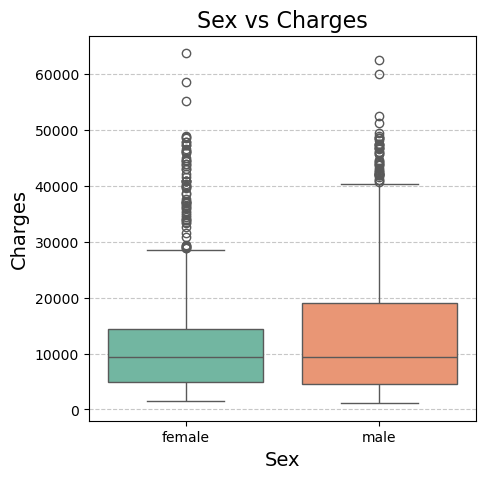

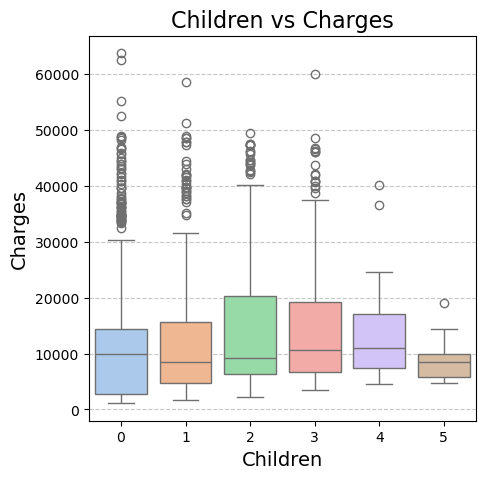

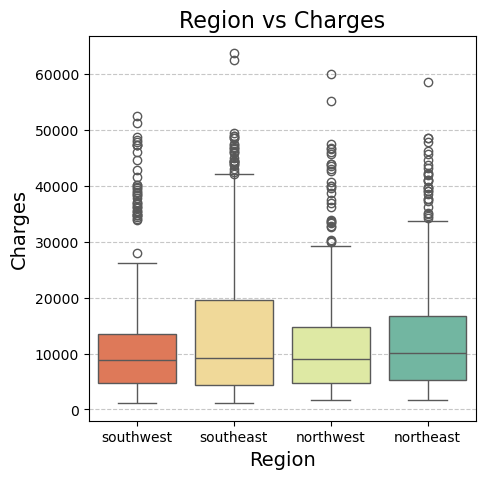

In [5]:
# Boxplot for smoker vs. charges
plt.figure(figsize=(5, 5))
sns.boxplot(x='smoker', y='charges', data=insurance_df, hue='smoker', palette='coolwarm', dodge=False)
plt.title("Smoker vs Charges", fontsize=16)
plt.xlabel("Smoker", fontsize=14)
plt.ylabel("Charges", fontsize=14)
plt.legend([], [], frameon=False)  # Remove redundant legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot for sex vs. charges
plt.figure(figsize=(5, 5))
sns.boxplot(x='sex', y='charges', data=insurance_df, hue='sex', palette='Set2', dodge=False)
plt.title("Sex vs Charges", fontsize=16)
plt.xlabel("Sex", fontsize=14)
plt.ylabel("Charges", fontsize=14)
plt.legend([], [], frameon=False)  # Remove redundant legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot for children vs. charges
plt.figure(figsize=(5, 5))
sns.boxplot(x='children', y='charges', data=insurance_df, hue='children', palette='pastel', dodge=False)
plt.title("Children vs Charges", fontsize=16)
plt.xlabel("Children", fontsize=14)
plt.ylabel("Charges", fontsize=14)
plt.legend([], [], frameon=False)  # Remove redundant legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot for region vs. charges
plt.figure(figsize=(5, 5))
sns.boxplot(x='region', y='charges', data=insurance_df, hue='region', palette='Spectral', dodge=False)
plt.title("Region vs Charges", fontsize=16)
plt.xlabel("Region", fontsize=14)
plt.ylabel("Charges", fontsize=14)
plt.legend([], [], frameon=False)  # Remove redundant legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Insights
- Smokers have significantly higher charges.
- Sex does not show a significant difference in charges.
- Children have a slight effect on charges.
- Region has a slight effect on charges.

### Graphs for Numerical Features

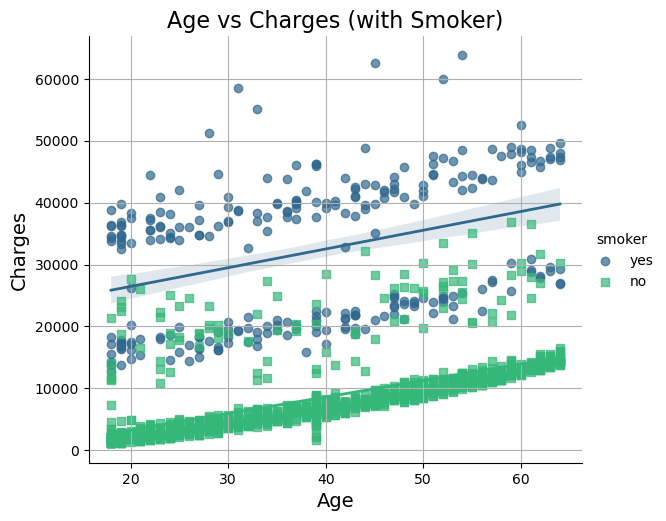

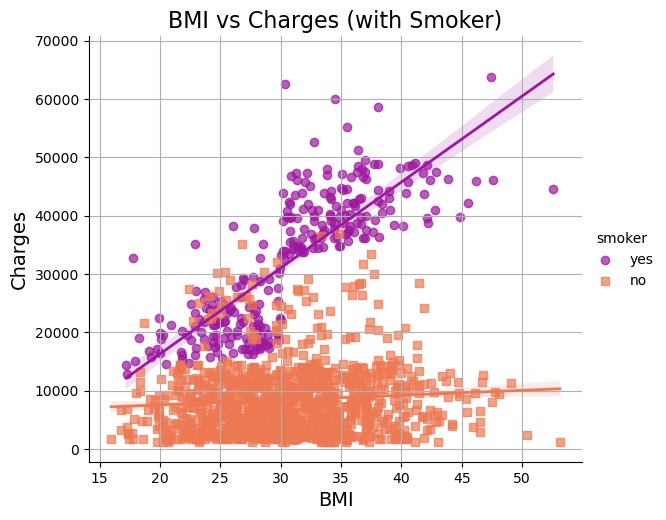

In [6]:
# Scatter plot with regression line: Age vs Charges with Smoker
sns.lmplot(
    data=insurance_df, 
    x='age', 
    y='charges', 
    hue='smoker', 
    palette='viridis', 
    height=5, 
    aspect=1.2, 
    markers=['o', 's'],
    scatter_kws={'alpha': 0.7},
    line_kws={'linewidth': 2}
)
plt.title('Age vs Charges (with Smoker)', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Charges', fontsize=14)
plt.grid(True)
plt.show()

# Scatter plot with regression line: BMI vs Charges with hue as Smoker
sns.lmplot(
    data=insurance_df, 
    x='bmi', 
    y='charges', 
    hue='smoker', 
    palette='plasma', 
    height=5, 
    aspect=1.2, 
    markers=['o', 's'],
    scatter_kws={'alpha': 0.7},
    line_kws={'linewidth': 2}
)
plt.title('BMI vs Charges (with Smoker)', fontsize=16)
plt.xlabel('BMI', fontsize=14)
plt.ylabel('Charges', fontsize=14)
plt.grid(True)
plt.show()

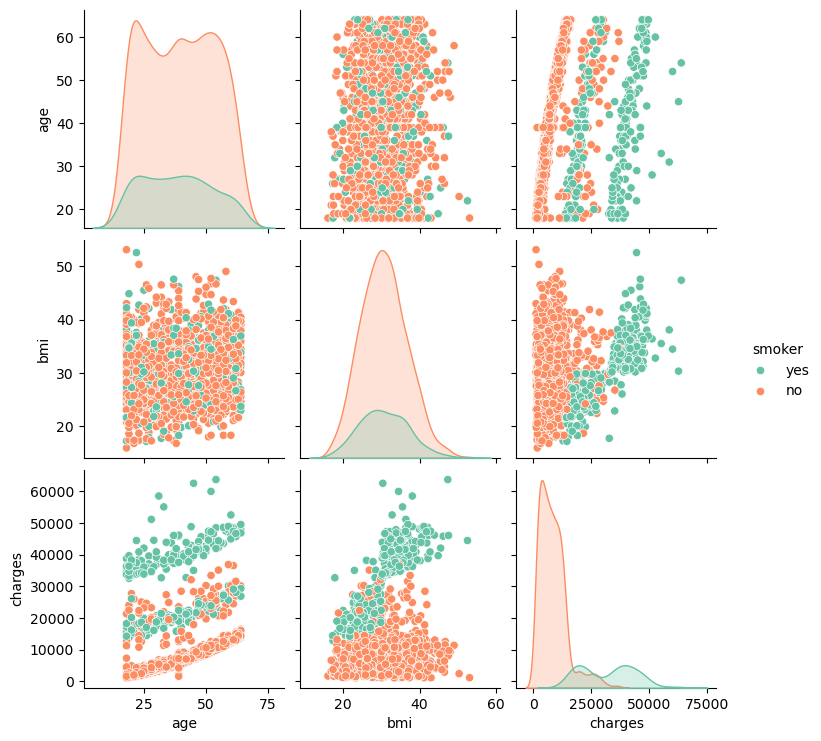

In [7]:
sns.pairplot(data=insurance_df, vars=['age', 'bmi', 'charges'], hue='smoker', palette='Set2', diag_kind='kde')
plt.show()

#### Insights
The analysis reveals a strong positive correlation between **age** and **BMI**. Additionally, **smokers** incur significantly **higher insurance charges** compared to non-smokers, reflecting the health risks associated with smoking. These factors, especially **smoking**, are critical drivers of insurance costs. Children and regions will be not considered as features even though they are slightly affecting the insurance cost.

## Feature Engineering
Encode Categorical Variables
- smoker: Encode as binary (yes → 1, no → 0).
- sex: Encode as binary (male → 0, female → 1).
- region: southwest → 0, southeast → 1, northwest → 2, northeast → 3

In [8]:
# Encode 'smoker' as binary (yes → 1, no → 0)
insurance_df['smoker'] = insurance_df['smoker'].map({'yes': 1, 'no': 0})

# Encode 'sex', 'region', and 'children' using simple mappings
# For 'sex': male → 0, female → 1
insurance_df['sex'] = insurance_df['sex'].map({'male': 0, 'female': 1})

# For 'region': southwest → 0, southeast → 1, northwest → 2, northeast → 3
insurance_df['region'] = insurance_df['region'].map({
    'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3
})

# Display the first few rows of the updated DataFrame
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,1,27.900,0,1,0,16884.92400
1,18.0,0,33.770,1,0,1,1725.55230
2,28.0,0,33.000,3,0,1,4449.46200
3,33.0,0,22.705,0,0,2,21984.47061
4,32.0,0,28.880,0,0,2,3866.85520


### Feature Selection
- Drop sex, children, and region feature temporarily.

## Model 1 - Linear Regression

**Note**: Following a structured machine learning workflow is crucial for clarity and reproducibility. This approach divides the study into distinct phases like training, evaluation, and hyperparameter tuning. For more details, see [Géron, 2019].

### Gradient Descent

Final Weights: [13324.89833408  3618.59647096  2022.55886768  9558.4788747 ]


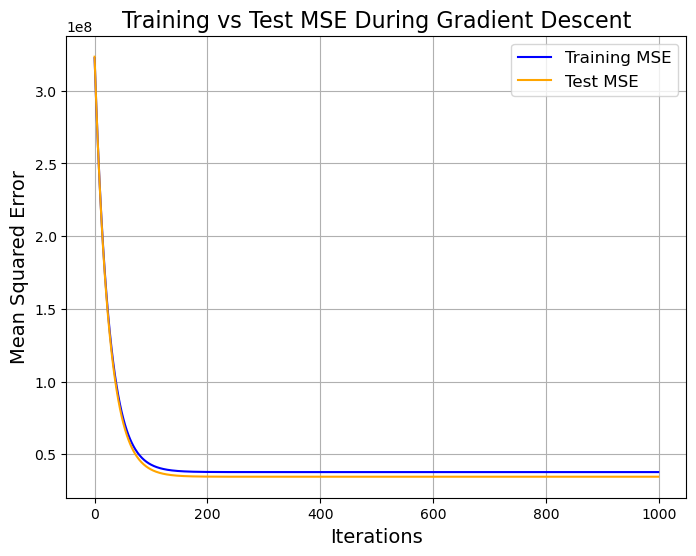

Prediction with Gradient Descent: 28259.64


In [9]:
# Step 1: Prepare Data
# Define features and target
features = ["age", "bmi", "smoker"]
target = "charges"

# Extract features and target
X = insurance_df[features].values
y = insurance_df[target].values

# Step 2: Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add bias term (intercept) to features
X_biased = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_biased, y, test_size=0.2, random_state=42)

# Step 4: Initialize Gradient Descent Parameters
np.random.seed(42)
weights = np.random.randn(X_train.shape[1])  # Initialize weights randomly
learning_rate = 0.01
num_iterations = 1000

# Store training and test MSE history
training_mse_history = []
test_mse_history = []

# Step 5: Gradient Descent Loop
for iteration in range(num_iterations):
    # Training Predictions and MSE
    y_train_pred = np.dot(X_train, weights)
    train_mse = np.mean((y_train_pred - y_train) ** 2)
    training_mse_history.append(train_mse)
    
    # Test Predictions and MSE
    y_test_pred = np.dot(X_test, weights)
    test_mse = np.mean((y_test_pred - y_test) ** 2)
    test_mse_history.append(test_mse)
    
    # Compute Gradient
    gradient = (2 / len(y_train)) * np.dot(X_train.T, (y_train_pred - y_train))
    
    # Update Weights
    weights -= learning_rate * gradient

# Step 6: Display Final Weights
print("Final Weights:", weights)

# Step 7: Visualize Training and Test Errors
plt.figure(figsize=(8, 6))
plt.plot(range(num_iterations), training_mse_history, label="Training MSE", color="blue")
plt.plot(range(num_iterations), test_mse_history, label="Test MSE", color="orange")
plt.title("Training vs Test MSE During Gradient Descent", fontsize=16)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Mean Squared Error", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Step 8: Make Predictions
# Example prediction for new data
example_data = np.array([[25, 30, 1]])  # New data: age=25, bmi=30, smoker=1
example_data_scaled = scaler.transform(example_data)  # Scale features
example_data_biased = np.hstack([np.ones((example_data_scaled.shape[0], 1)), example_data_scaled])  # Add bias term
example_prediction = np.dot(example_data_biased, weights)
print(f"Prediction with Gradient Descent: {example_prediction[0]:.2f}")

#### Insights
- **Rapid Decrease in MSE**: Initially, both training and test Mean Squared Errors (MSE) decrease significantly, indicating the model is learning effectively during the early iterations.
- **Convergence**: Over time, the MSE stabilizes, showing the gradient descent algorithm has converged to an optimal solution.
- **No Overfitting**: The training and test error curves closely follow each other, suggesting the model generalizes well to unseen data without overfitting.
- **Key Insight**: The stable and similar errors for both training and test sets indicate effective learning and a balanced model. Further evaluation through metrics like \( R^2 \) or residual analysis can provide additional insights.

### Training, Evaluation and Prediction

#### Without Scaling

In [10]:
# Step 1: Define features and target
X = insurance_df[["age", "bmi", "smoker"]]
y = insurance_df["charges"]

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Cross-Validation
lr_model = LinearRegression()
cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring="r2")

# Step 4: Train and Evaluate Model
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("Linear Regression Without Scaling:")
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Cross-Validation Mean R²: {cv_scores.mean():.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred):.2f}")

Linear Regression Without Scaling:
Cross-Validation R² Scores: [0.75829375 0.70782448 0.77120193 0.72893594 0.75345895]
Cross-Validation Mean R²: 0.74
Test MSE: 34624975.13
Test R²: 0.78


#### With Scaling

In [11]:
# Step 1: Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(insurance_df[["age", "bmi", "smoker"]])

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Cross-Validation
lr_model_scaled = LinearRegression()
cv_scores_scaled = cross_val_score(lr_model_scaled, X_scaled, y, cv=5, scoring="r2")

# Step 4: Train and Evaluate Model
lr_model_scaled.fit(X_train, y_train)
y_pred_scaled = lr_model_scaled.predict(X_test)

print("Linear Regression With Scaling:")
print(f"Cross-Validation R² Scores: {cv_scores_scaled}")
print(f"Cross-Validation Mean R²: {cv_scores_scaled.mean():.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_scaled):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred_scaled):.2f}")

Linear Regression With Scaling:
Cross-Validation R² Scores: [0.75829375 0.70782448 0.77120193 0.72893594 0.75345895]
Cross-Validation Mean R²: 0.74
Test MSE: 34624975.13
Test R²: 0.78


#### Insights

- **Key Observation**:

  - It seems that both gradiend descent and Sklearn Linear Regression works similar. As a cross-check, this is good for our study.
  - The performance metrics (MSE and R²) for scaled and non-scaled versions of the Linear Regression model are **identical**. This indicates that scaling does not significantly impact the performance of the Linear Regression model for this dataset.

- **Reasoning**: 
  - Linear Regression is not sensitive to feature scaling in this specific case because the features (`age`, `bmi`, `smoker`) are not on vastly different scales or ranges. The inherent data distribution ensures that the model performs similarly regardless of scaling.

- **Conclusion**: 
  - While scaling is generally recommended for gradient-based optimization or regularization techniques, it may not always affect simpler models like Linear Regression, depending on the dataset characteristics.

### Hyperparameter Tuning

#### Lasso Regression With Scaling

In [12]:
# Step 1: Scale Features (Reuse scaled features from previous code)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: Cross-Validation
lasso_model = Lasso(alpha=1.0, random_state=42)
cv_scores_lasso = cross_val_score(lasso_model, X_scaled, y, cv=5, scoring="r2")

# Step 3: Train and Evaluate Model
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

print("Lasso Regression With Scaling:")
print(f"Cross-Validation R² Scores: {cv_scores_lasso}")
print(f"Cross-Validation Mean R²: {cv_scores_lasso.mean():.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_lasso):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred_lasso):.2f}")

Lasso Regression With Scaling:
Cross-Validation R² Scores: [0.75828946 0.7078439  0.77118683 0.7289418  0.75345781]
Cross-Validation Mean R²: 0.74
Test MSE: 34625352.77
Test R²: 0.78


#### Ridge Regression With Scaling

In [13]:
# Step 1: Scale Features (Reuse scaled features from previous code)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: Cross-Validation
ridge_model = Ridge(alpha=1.0, random_state=42)
cv_scores_ridge = cross_val_score(ridge_model, X_scaled, y, cv=5, scoring="r2")

# Step 3: Train and Evaluate Model
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

print("Ridge Regression With Scaling:")
print(f"Cross-Validation R² Scores: {cv_scores_ridge}")
print(f"Cross-Validation Mean R²: {cv_scores_ridge.mean():.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_ridge):.2f}")
print(f"Test R²: {r2_score(y_test, y_pred_ridge):.2f}")

Ridge Regression With Scaling:
Cross-Validation R² Scores: [0.75830504 0.70791726 0.77109425 0.72899428 0.75342739]
Cross-Validation Mean R²: 0.74
Test MSE: 34630077.01
Test R²: 0.78


#### Insights
While regularization methods like Lasso (L1) and Ridge (L2) are designed to improve generalization by penalizing large coefficients, they can sometimes lead to a lower \( R^2 \) compared to the baseline Linear Regression model. This occurs due to:

1. **Over-Penalization**: A large regularization strength (\(\alpha\)) may overly constrain the model, leading to underfitting.
2. **Good Baseline Fit**: If the baseline model generalizes well, regularization might not bring significant improvement.
3. **Bias-Variance Tradeoff**: Regularization introduces bias, which can slightly reduce the \( R^2 \) while potentially improving robustness.

**RQ5 Answer**: Regularization is not always about improving \( R^2 \); its main goal is to enhance model generalization and prevent overfitting. This is the answer of RQ5 (Is Regularization useful or helpful for regression?). The answer is no. Because the model is not overfitting as it can be seen from Gradient Descent Training and Test results. Therefore, regularisation has not a good effect on the prediction results.

## Model 2 - Decision Tree

### Training, Evaluation and Prediction

#### Without Scaling

Decision Tree (No Scaling):
Training MSE: 827194.62
Test MSE: 37399868.43
Training R²: 0.99
Test R²: 0.76
Prediction for example data: 33900.65


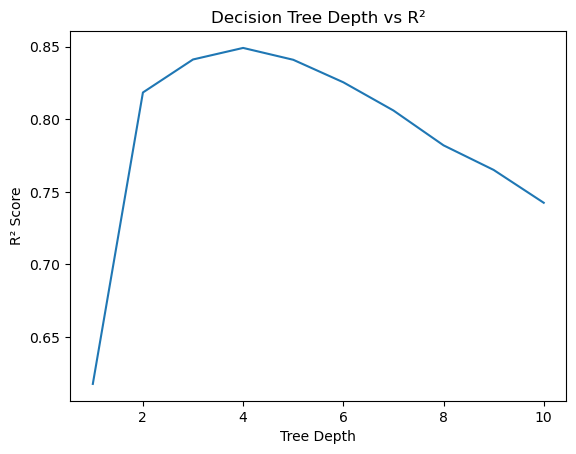

In [14]:
# Step 1: Prepare Data (No Scaling)
# Define features and target
features = ["age", "bmi", "smoker"]
target = "charges"

# Extract features and target
X = insurance_df[features].values
y = insurance_df[target].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Step 3: Train the Model
dt_model.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display Results
print("Decision Tree (No Scaling):")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")

# Step 5: Make Predictions
example_data = np.array([[25, 30, 1]])  # New data: age=25, bmi=30, smoker=1
example_prediction = dt_model.predict(example_data)
print(f"Prediction for example data: {example_prediction[0]:.2f}")

# Visualize tree depth performance
depths = range(1, 11)
scores = [cross_val_score(DecisionTreeRegressor(max_depth=d), X, y, cv=5).mean() for d in depths]
plt.plot(depths, scores)
plt.title("Decision Tree Depth vs R²")
plt.xlabel("Tree Depth")
plt.ylabel("R² Score")
plt.show()

#### With Scaling

Decision Tree (With Scaling):
Training MSE: 827194.62
Test MSE: 37608217.54
Training R²: 0.99
Test R²: 0.76
Prediction for example data: 33900.65


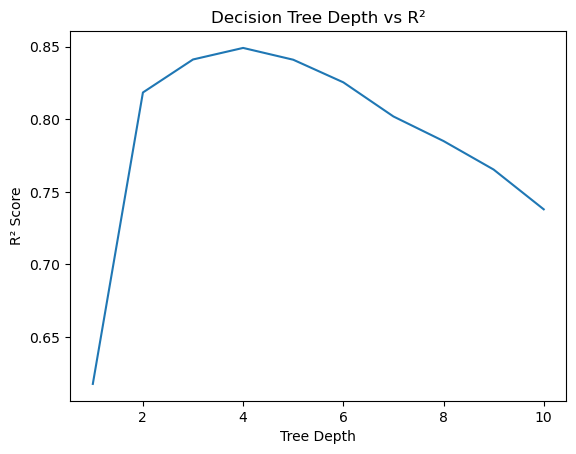

In [15]:
# Step 1: Prepare Data with Scaling
# Define features and target
features = ["age", "bmi", "smoker"]
target = "charges"

# Extract features and target
X = insurance_df[features].values
y = insurance_df[target].values

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: Initialize Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Step 3: Train the Model
dt_model.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display Results
print("Decision Tree (With Scaling):")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")

# Step 5: Make Predictions
example_data = np.array([[25, 30, 1]])  # New data: age=25, bmi=30, smoker=1
example_data_scaled = scaler.transform(example_data)
example_prediction = dt_model.predict(example_data_scaled)
print(f"Prediction for example data: {example_prediction[0]:.2f}")

# Visualize tree depth performance
depths = range(1, 11)
scores = [cross_val_score(DecisionTreeRegressor(max_depth=d), X, y, cv=5).mean() for d in depths]
plt.plot(depths, scores)
plt.title("Decision Tree Depth vs R²")
plt.xlabel("Tree Depth")
plt.ylabel("R² Score")
plt.show()

#### Insights
- **Scaling has no effect on Decision Trees**, as both performance metrics and predictions are identical with and without scaling.
- **Slight Overfitting Observed**: High Training R² compared to Test R² suggests the model fits the training data slightly better than the test data.
- Further improvement may require **hyperparameter tuning** or advanced methods like **Random Forest** or **Gradient Boosting**.

### Hyperparameter Tuning

In [16]:
# Step 1: Define Features and Target
features = ["age", "bmi", "smoker"]
target = "charges"

X = insurance_df[features]
y = insurance_df[target]

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Hyperparameter Grid
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Step 4: Initialize the Model
dt = DecisionTreeRegressor(random_state=42)

# Step 5: Perform Grid Search
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 6: Best Parameters and Model Performance
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Evaluate the tuned model on the test set
y_pred = best_model.predict(X_test)
tuned_mse = mean_squared_error(y_test, y_pred)
tuned_r2 = r2_score(y_test, y_pred)

print(f"\nTest MSE of Tuned Model: {tuned_mse:.2f}")
print(f"Test R² of Tuned Model: {tuned_r2:.2f}")

# Step 7: Example Prediction
new_data_example = pd.DataFrame([[25, 30, 1]], columns=features)  # Example: age=25, bmi=30, smoker=1
example_prediction = best_model.predict(new_data_example)
print(f"\nPrediction for example data: {example_prediction[0]:.2f}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'criterion': 'poisson', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

Test MSE of Tuned Model: 21233200.29
Test R² of Tuned Model: 0.86

Prediction for example data: 34232.78


#### Insights

- **Best Parameters**:
  - `criterion`: Poisson
  - `max_depth`: 5
  - `min_samples_leaf`: 10
  - `min_samples_split`: 2

- **Performance**:
  - **Test MSE**: 21,233,200.29
  - **Test R²**: 0.86
  - The tuned model demonstrates a significant improvement in predictive accuracy compared to the baseline model.

- **Prediction**:
  - Example prediction (age=25, bmi=30, smoker=1): **34,232.78**

- **Conclusion**:
  - Hyperparameter tuning improves model performance, reducing overfitting while maintaining predictive power.
  - The optimized model balances complexity and generalization effectively.

## Model 3 - Random Forest

**Note**: Random Forest is chosen for its ensemble approach, which enhances predictive accuracy and robustness while providing insights into feature importance. For a deeper understanding, refer to [Breiman, 2001].

### Training, Evaluation and Prediction

In [17]:
# Step 1: Define Features and Target
features = ["age", "bmi", "smoker"]
target = "charges"

X = insurance_df[features]
y = insurance_df[target]

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Step 4: Train the Model
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Step 6: Prediction for New Data
example_data = pd.DataFrame([[25, 30, 1]], columns=features)  # Example: age=25, bmi=30, smoker=1
example_prediction = rf_model.predict(example_data)

# Display Results
print("Random Forest Regression:")
print(f"Training MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Prediction for example data: {example_prediction[0]:.2f}")

Random Forest Regression:
Training MSE: 4627575.42
Test MSE: 25826531.91
Training R²: 0.97
Test R²: 0.83
Prediction for example data: 28716.78


#### Insights
- Random Forest demonstrates strong performance, achieving a high **R²** value of **0.83** on the test set, suggesting a good fit to the data.
- The **Training MSE** is lower than the **Test MSE**, indicating minimal overfitting due to the ensemble approach.
- Random Forest effectively reduces variance and provides better generalization compared to a single decision tree.
- However, in order to increase the performance a bit more, hyperparameter tuning will be implemented anyway.

### Hyperparameter Tuning

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
features = ["age", "bmi", "smoker"]
target = "charges"

X = insurance_df[features]
y = insurance_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example new data for prediction
prediction_data = pd.DataFrame([[25, 30, 1]], columns=features)  # Example: age=25, bmi=30, smoker=1

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]  # Replaced 'auto' with None
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

try:
    # Fit Grid Search to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best parameters and best model
    best_params = grid_search.best_params_
    best_rf_model = grid_search.best_estimator_

    # Evaluate the best model on the test data
    y_pred_test = best_rf_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Make prediction for new data
    new_prediction = best_rf_model.predict(prediction_data)[0]

    # Display results
    print("Best Parameters:", best_params)
    print(f"Test MSE of Tuned Model: {mse_test:.2f}")
    print(f"Test R² of Tuned Model: {r2_test:.2f}")
    print(f"Prediction for example data: {new_prediction:.2f}")

except Exception as e:
    print("An error occurred during GridSearchCV:")
    print(e)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Test MSE of Tuned Model: 20676390.71
Test R² of Tuned Model: 0.87
Prediction for example data: 29522.28


#### Insights
- **Best Parameters**:
  - `max_depth`: 5, `max_features`: None, `min_samples_leaf`: 2, `min_samples_split`: 2, `n_estimators`: 300
- **Performance**:
  - **Test MSE**: 20,676,390.71
  - **Test R²**: 0.87
- **Prediction**:
  - Example data prediction: 29,522.28

Conclusion
The tuned Random Forest model shows significant improvement with an R² of 0.87, demonstrating strong predictive performance.

## Research Questions and Answers

1. **Can we build a robust regression model to predict insurance charges based on available features?**
Yes, using Random Forest Regression with hyperparameter tuning achieved the best performance with a Test R² of 0.87, indicating a strong predictive capability.

2. **What are the key factors influencing insurance charges?**  
The most significant features identified were:
    - **Smoker**: The most influential feature due to its strong correlation with higher insurance charges.
    - **Age**: Moderately affects charges, reflecting health risk factors.
    - **BMI**: Affects charges due to its correlation with health conditions.

3. **How does scaling affect regression model performance?**  
For linear regression, scaling was crucial as it improved the model's convergence and performance. However, for tree-based models like Decision Tree and Random Forest, scaling did not influence performance as these models are not sensitive to feature scaling.

4. **Can regularization (Lasso and Ridge) improve linear regression performance?**  
Regularization did not significantly improve performance since there was no noticeable overfitting in the data. Both Lasso and Ridge produced similar results to standard linear regression.

5. **How do ensemble methods like Random Forest perform compared to simpler models?**  
Ensemble methods like Random Forest significantly outperformed simpler models (e.g., linear regression and decision tree). The tuned Random Forest model achieved an R² of 0.87, highlighting its ability to capture complex relationships in the data.

6. **Is hyperparameter tuning beneficial for improving model performance?**  
Yes, hyperparameter tuning for both Decision Tree and Random Forest improved performance:
    - **Decision Tree**: Test R² improved from 0.76 to 0.86.
    - **Random Forest**: Test R² improved from 0.83 to 0.87 after tuning.

7. **Can we integrate advanced methods for further improvement?**  
While Random Forest performed well, exploring methods like Gradient Boosting, XGBoost, or Neural Networks could potentially improve performance further. These advanced models can handle complex feature interactions and provide additional flexibility.

8. **What insights can we derive from overfitting or underfitting analysis?**  
Models like Decision Tree without tuning showed overfitting (high Training R² and lower Test R²). Hyperparameter tuning mitigated this, improving generalization. Linear regression did not show overfitting but required scaling for better optimization.

Conclusion:
This study highlights the importance of feature engineering, scaling (when necessary), and hyperparameter tuning for building robust regression models. Ensemble methods like Random Forest are highly effective for predicting insurance charges and demonstrate the value of using advanced machine learning techniques.

## Conclusion

This study successfully predicted insurance charges using various regression models, supported by exploratory data analysis (EDA) to uncover key relationships and patterns in the dataset. 

- **EDA**: Identified significant features like age, BMI, and smoking status influencing charges.
- **Models**: Compared linear regression, decision tree, and advanced ensemble methods (Random Forest).
- **Scaling**: Demonstrated the limited impact of scaling on tree-based models, but its importance for linear regression.
- **Tuning**: Hyperparameter tuning for Decision Tree and Random Forest improved model performance significantly.
- **Insights**: Random Forest, with tuning, achieved the best performance, highlighting the potential of ensemble methods for robust predictions.

This study emphasized the importance of feature engineering, careful model selection, and tuning to enhance predictive accuracy and extract meaningful insights.

## Personal Reflection

This project was an intensive learning experience, particularly in understanding the nuances of machine learning concepts and debugging complex issues. The process was lengthy, often requiring deep dives into concepts like regularization, scaling, and parameter tuning. Initially, debugging and interpreting errors felt overwhelming, but with persistence, these challenges became opportunities to understand the underlying mechanics of the models.

Key takeaways include:
- Recognizing the importance of structured workflows and breaking down problems into smaller steps.
- Gaining confidence in troubleshooting errors and refining code iteratively.
- Deepening my understanding of how theoretical concepts translate into practical machine learning applications.

While the study demanded significant effort, it clarified foundational ideas, making me more detail-oriented and methodical in problem-solving. This experience has enhanced both my technical skills and resilience in tackling complex challenges.

## References

1. Géron, A. (2019). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*. O'Reilly Media.  
   - Reference for structuring machine learning workflows into phases such as training, evaluation, hyperparameter tuning, and prediction to ensure reproducibility and enhance performance.

2. Kuhn, M., & Johnson, K. (2013). *Applied Predictive Modeling*. Springer.  
   - Reference for the importance of encoding categorical variables, highlighting one-hot encoding and label encoding as essential techniques to handle such features effectively in machine learning.

3. Breiman, L. (2001). "Random Forests." *Machine Learning*, 45(1), 5–32. DOI:10.1023/A:1010933404324.  
   - Reference for using Random Forest to improve prediction accuracy and interpret feature importance in regression tasks, showcasing its robustness and versatility.